In [1]:
# Common initialisation, constants, etc.

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=4)
plt.rc('figure', dpi=200)
plt.rc('axes', axisbelow=True, titlesize=5)
plt.rc('lines', linewidth=1)
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.animation import FuncAnimation

# Define some useful array accessor constants
POS_X  = 0    # x-coordinates of agents position
POS_Y  = 1    # y-coordinates of agents position
COH_X  = 2    # x-coordinates of cohesion vectors
COH_Y  = 3    # y-coordinates of cohesion vectors
REP_X  = 4    # x-coordinates of repulsion vectors
REP_Y  = 5    # y-coordinates of repulsion vectors
DIR_X  = 6    # x-coordinates of direction vectors
DIR_Y  = 7    # y-coordinates of direction vectors
RES_X  = 8    # x-coordinates of resultant vectors
RES_Y  = 9    # y-coordinates of resultant vectors
GOAL_X = 10   # x-coordinates of goals
GOAL_Y = 11   # y-coordinates of goals
CF     = 12   # cohesion field radii
RF     = 13   # repulsion field radii
KC     = 14   # cohesion vector scaling factor
KR     = 15   # repulsion vector scaling factor
KD     = 16   # direction vector scaling factor
KG     = 17   # gap reduction scaling factor
PRM    = 18   # if True agent known to be on perimeter of swarm
GAP_X  = 19   # x-coordinates of vector for gap reduction
GAP_Y  = 20   # y-ccordinates of vector for gap reduction
COH_N  = 21   # number of cohesion neighbours
REP_N  = 22   # number of repulsion neighbours

N_ROWS = 23   # number of rows in array that models swarm state
eps    = np.finfo('float64').eps # smallest positive 64 bit float value

default_swarm_params = {
    'cb' : 4.0,
    'rb' : 3.0,
    'ob' : 3.0,
    'kc' : 1.0,
    'kr' : 1.0,
    'kd' : 0.0,
    'ko' : 0.0,
    'kg' : 0.0,
    'scaling' : 'linear',
    'exp_rate' : 0.2,
    'speed' : 0.05,
    'stability_factor' : 0.0,
    'pr' : [[1.0,1.0],[1.0,1.0]],
    'pkc' : [[1.0,1.0],[1.0,1.0]],
    'pkr': [[1.0,1.0],[1.0,1.0]]
}

def mk_rand_swarm(n, *, cb=4.0, rb=3.0, kc=1.0, kr=1.0, kd=0.0, kg=0.0, goal=[[0.0], [0.0]], loc=0.0, grid=10, seed=None):
    '''
    create a 2-D array of N_ROWS attributes for n agents.

    :param n:      number of agents
    :param cb:     cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rb:     repulsion field radius of all agents; default 3.0
    :param kc:     weighting factor for cohesion component, default 1.0
    :param kr:     weighting factor for repulsion component, default 1.0
    :param kd:     weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param kg:     weighting factor for gap reduction, default 0.0 (i.e. no gap reduction by default)
    :param goal:   location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    :param loc:    location of agent b_0 -- the focus of the swarm
    :param grid:   size of grid around b_0 in which all other agents will be placed initially at random
    '''
    b = np.empty((N_ROWS, n))                       #create a 2-D array, big enough for n agents
    prng = np.random.default_rng(seed)
    np.copyto(b[POS_X:POS_Y + 1,:], (prng.random(size=2 * n) * 2 * grid - grid + loc).reshape(2, n)) # place agents randomly
    b[POS_X:POS_Y + 1,0] = loc                      # b_0 placed at [loc, loc]
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal[0], goal[1]], default [0.0, 0.0]
    b[CF,:] = cb                                    # cohesion field of all agents set to cb
    b[RF,:] = rb                                    # repulsion field of all agents set to rb
    b[KC,:] = kc                                    # cohesion weight for all agents set to kc
    b[KR,:] = kr                                    # repulsion weight for all agents set to kr
    b[KD,:] = kd                                    # direction weight for all agents set to kd
    b[KG,:] = kg                                    # gap reduction weight for all agents set to kg
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[GAP_X:GAP_Y+1,:] = 0.                         # gap vectors initially [0.0, 0.0]
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

def mk_swarm(xs, ys, *, cb=4.0, rb=3.0, kc=1.0, kr=1.0, kd=0.0, kg=0.0, goal=[[0.0], [0.0]]):
    '''
    create a 2-D array of N_ROWS attributes for len(xs) agents.

    :param xs:      x-values of position of agents
    :param ys:      y-values of position of agents
    :param cb:      cohesion field radius of all agents; default 4.0; heterogeneous fields are allowed but not catered for here
    :param rb:      repulsion field radius of all agents; default 3.0
    :param kc:      weighting factor for cohesion component, default 1.0
    :param kr:      weighting factor for repulsion component, default 1.0
    :param kd:      weighting factor for direction component, default 0.0 (i.e. goal is ignored by default)
    :param goal:    location of a goal for all agents; heterogeneous goals are allowed but not catered for here
    '''
    n = len(xs)
    assert len(ys) == n
    b = np.empty((N_ROWS, n))                       # create a 2-D array, big enough for n agents
    np.copyto(b[POS_X], xs)                         # place agents as specified
    np.copyto(b[POS_Y], ys)                         # place agents as specified
    b[COH_X:COH_Y+1,:] = 0.                         # cohesion vectors initially [0.0, 0.0]
    b[REP_X:REP_Y+1,:] = 0.                         # repulsion vectors initially [0.0, 0.0]
    b[DIR_X:DIR_Y+1,:] = 0.                         # direction vectors initially [0.0, 0.0]
    b[RES_X:RES_Y + 1,:] = 0.                       # resultant vectors initially [0.0, 0.0]
    b[GOAL_X:GOAL_Y + 1,:] = goal                   # goal is at [goal, goal], default [0.0, 0.0]
    b[CF,:] = cb                                    # cohesion field of all agents set to cb
    b[RF,:] = rb                                    # repulsion field of all agents set to rb
    b[KC,:] = kc                                    # cohesion weight for all agents set to kc
    b[KR,:] = kr                                    # repulsion weight for all agents set to kr
    b[KD,:] = kd                                    # direction weight for all agents set to kd
    b[KG,:] = kg                                    # gap reduction weight for all agents set to kg
    b[PRM,:] = False                                # initially no agents known to be on perimeter
    b[GAP_X:GAP_Y+1,:] = 0.                         # gap vectors initially [0.0, 0.0]
    b[COH_N,:] = 0.                                 # initially no cohesion neighbours
    b[REP_N,:] = 0.                                 # initially no repulsion neighbours
    return b

In [2]:
# Numba-accelerated simulator

from numba import jit, prange

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def all_pairs_mag(b, xv, yv, mag, ecb):
    n_agents = b.shape[1]
    b[COH_N].fill(0.)
    for i in range(n_agents):
        for j in range(i):
            xv[i,j] = b[POS_X][i] - b[POS_X][j]
            xv[j,i] = -xv[i,j]
            yv[i,j] = b[POS_Y][i] - b[POS_Y][j]
            yv[j,i] = -yv[i,j]
            mag[i,j] = np.sqrt(xv[i,j] ** 2 + yv[i,j] ** 2)
            mag[j,i] = mag[i,j]
            if mag[j,i] <= ecb[j,i]:
                b[COH_N][i] = b[COH_N][i] + 1
                b[COH_N][j] = b[COH_N][j] + 1
        xv[i,i] = 0.0
        yv[i,i] = 0.0
        mag[i,i] = 0.0

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_coh(b, xv, yv, mag, ecb, ekc):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[COH_X][i] = 0.0
        b[COH_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= ecb[j, i]:
                b[COH_X][i] = b[COH_X][i] + (xv[j,i] * ekc[i,j])
                b[COH_Y][i] = b[COH_Y][i] + (yv[j,i] * ekc[i,j])

@jit(nopython=True, fastmath=True, cache=True)
def nbr_sort(a, ang, i):
    n = a.shape[0]
    for j in range(n):
        jmin = j
        for k in range(j, n):
            if (ang[:,i][a[k]] < ang[:,i][a[jmin]]):
                jmin = k
        if jmin != j:
            a[jmin], a[j] = a[j], a[jmin]


@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def onPerim(b, xv, yv, mag, ecb):
    n_agents = b.shape[1]
    result = np.full(n_agents, False)
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    for i in prange(n_agents):
        b[GAP_X][i] = 0.
        b[GAP_Y][i] = 0.
        if b[COH_N][i] < 3:
            result[i] = True
            continue
        nbrs = np.full(int(b[COH_N][i]), 0)
        k = 0
        for j in range(n_agents):
            if j != i and mag[j, i] <= ecb[i, j]:
                nbrs[k] = j
                k += 1
        nbr_sort(nbrs, ang, i)
        for j in range(int(b[COH_N][i])):
            k = (j + 1) % int(b[COH_N][i])
            if mag[nbrs[k],nbrs[j]] > ecb[nbrs[k],nbrs[j]]:    # nbrs[j] and nbrs[k] are not cohesion neighbours
                result[i] = True
                # compute the gap vector in case of gap reduction
                b[GAP_X][i] += (b[KG][i] * ((0.5 * (b[POS_X][nbrs[k]] + b[POS_X][nbrs[j]])) - b[POS_X][i]))
                b[GAP_Y][i] += (b[KG][i] * ((0.5 * (b[POS_Y][nbrs[k]] + b[POS_Y][nbrs[j]])) - b[POS_Y][i]))
                break
            else:
                delta = ang[:,i][nbrs[k]] - ang[:,i][nbrs[j]]
                if (delta < 0):
                    delta += np.pi * 2.0;
                if (delta > np.pi):
                    result[i] = True;
                    # compute the gap vector in case of gap reduction
                    b[GAP_X][i] += (b[KG][i] * ((0.5 * (b[POS_X][nbrs[k]] + b[POS_X][nbrs[j]])) - b[POS_X][i]))
                    b[GAP_Y][i] += (b[KG][i] * ((0.5 * (b[POS_Y][nbrs[k]] + b[POS_Y][nbrs[j]])) - b[POS_Y][i]))
                    break
    return result, ang


@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_erf(b, pr, pkc, pkr):
    n_agents = b.shape[1]
    p = b[PRM].astype(np.int64)
    erf = np.empty((n_agents, n_agents))
    ekc = np.empty((n_agents, n_agents))
    ekr = np.empty((n_agents, n_agents))
    for i in prange(n_agents):
        for j in range(n_agents):
            erf[i,j] = b[RF][i] * pr[p[i],p[j]]
            ekc[i,j] = b[KC][i] * pkc[p[i],p[j]]
            ekr[i,j] = b[KR][i] * pkr[p[i],p[j]]
    return erf, ekc, ekr

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_linear(b, xv, yv, mag, erf, ekr):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (1. - (erf[i,j] / mag[j,i])) * xv[j,i] * ekr[i,j]
                b[REP_Y][i] = b[REP_Y][i] + (1. - (erf[i,j] / mag[j,i])) * yv[j,i] * ekr[i,j]

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_quadratic(b, xv, yv, mag, erf, ekr):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-erf[i,j] * (mag[j,i] ** -2) * (xv[j,i] / mag[j,i]) * ekr[i,j])
                b[REP_Y][i] = b[REP_Y][i] + (-erf[i,j] * (mag[j,i] ** -2) * (yv[j,i] / mag[j,i]) * ekr[i,j])

@jit(nopython=True, fastmath=True, parallel=True, cache=True)
def compute_rep_exponential(b, xv, yv, mag, erf, ekr, exp_rate):
    n_agents = b.shape[1]
    for i in prange(n_agents):
        b[REP_N][i] = 0.0
        b[REP_X][i] = 0.0
        b[REP_Y][i] = 0.0
        for j in range(n_agents):
            if j != i and mag[j, i] <= erf[i,j]:
                b[REP_N][i] = b[REP_N][i] + 1
                b[REP_X][i] = b[REP_X][i] + (-erf[i,j] * (np.e ** (-mag[j,i] * exp_rate)) * (xv[j,i] / mag[j,i]) * ekr[i,j])
                b[REP_Y][i] = b[REP_Y][i] + (-erf[i,j] * (np.e ** (-mag[j,i] * exp_rate)) * (yv[j,i] / mag[j,i]) * ekr[i,j])

@jit(nopython=True, fastmath=True, cache=True)
def update_resultant(b, stability_factor, speed):
    n_agents = b.shape[1]
    for i in range(n_agents):
        mag_res = np.sqrt(b[RES_X][i] ** 2 + b[RES_Y][i] ** 2)
        if mag_res > stability_factor * speed:
            b[RES_X][i] = b[RES_X][i] / mag_res * speed
            b[RES_Y][i] = b[RES_Y][i] / mag_res * speed
        else:
            b[RES_X][i] = 0.0
            b[RES_Y][i] = 0.0

def compute_step(b, *, scaling='linear', exp_rate=1.2, speed=0.05, perim_coord=False, stability_factor=0.0, pr=np.array([[1.0,1.0],[1.0,1.0]]), pkc=np.array([[1.0,1.0],[1.0,1.0]]), pkr=np.array([[1.0,1.0],[1.0,1.0]])):
    """
    Compute one step in the evolution of swarm `b`, update the COH, REP, DIR and RES fields
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param pc: determines the amount by which the cohesion weight should be increased for perimeter agents
                                     e.g. a pc of 2.0 causes the size of the cohesion weight to be doubled
    :param pr: determines the amount by which the repulsion field should be reduced for perimeter agents,
                                     e.g. a pr of 0.5 causes the size of the repulsion field to be halved
    """
    # print(scaling, exp_rate, speed, perim_coord, stability_factor, pr)
    n_agents = b.shape[1]
    ecb = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
    xv = np.empty((n_agents, n_agents))
    yv = np.empty((n_agents, n_agents))
    mag = np.empty((n_agents, n_agents))
    all_pairs_mag(b, xv, yv, mag, ecb)

    # compute the perimeter, including gap vectors for gap reduction
    b[PRM], ang = onPerim(b, xv, yv, mag, ecb)

   # compute the effective repulsion field, cohesion weight and repulsion weight
    erf, ekc, ekr = compute_erf(b, pr, pkc, pkr)

    # compute the cohesion vectors
    compute_coh(b, xv, yv, mag, ecb, ekc)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        compute_rep_linear(b, xv, yv, mag, erf, ekr)
    elif scaling == 'quadratic':
        compute_rep_quadratic(b, xv, yv, mag, erf, ekr)
    elif scaling == 'exponential':
        compute_rep_exponential(b, xv, yv, mag, erf, ekr, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours

    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[DIR_X:DIR_Y+1] *= b[PRM]
    b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[GAP_X:GAP_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]

    # normalise the resultant and update for speed, adjusted for stability
    update_resultant(b, stability_factor, speed)

    return xv, yv, mag, ang, ecb, erf, ekc, ekr         # helpful in calculation of metrics, instrumentation, debugging

def apply_step(b):
    """
    Assuming the step has been computed so that RES fields are up to date, update positions
    """
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]
    np.around(b[POS_X:POS_Y+1], 9, out=b[POS_X:POS_Y+1])

def d_step(b, *, scaling='linear', exp_rate=1.2, speed=0.05, perim_coord=False, stability_factor=0.0, pr=np.array([[1.0,1.0],[1.0,1.0]]), pkc=np.array([[1.0,1.0],[1.0,1.0]]), pkr=np.array([[1.0,1.0],[1.0,1.0]])):
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, pr=pr, pkc=pkc, pkr=pkr)
    apply_step(b)
    return xv,yv,mag,ang,ecf,erf,ekc,ekr

In [3]:
# Latest pure numpy model (for comparison)

def all_pairs_mag2(b):
    xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
    yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
    # compute all pairwise vector magnitudes
    mag = np.hypot(xv, yv)              # all pairs magnitudes
    return xv, yv, mag

def compute_coh2(b, xv, yv, ekc, coh_n):
    # compute the x-differences and y-differences for cohesion vectors
    xv_coh = np.where(coh_n, xv * ekc, 0.0)
    yv_coh = np.where(coh_n, yv * ekc, 0.0)

    # compute the cohesion vectors 
    b[COH_X] = xv_coh.sum(axis=0)                       # sum the x-differences 
    b[COH_Y] = yv_coh.sum(axis=0)                       # sum the y-differences
    return coh_n, xv_coh, yv_coh

def onPerim2(b, xv=None, yv=None, mag=None, coh_n=None, ecf=None):
    """
    Determines the perimeter status of all agents in swarm b. Can make use of previous computations,
    if available, to improve overall efficiency.
    
    :param b: a data structure representing the swarm
    :param xv: all pairs differences in x-values
    :param yv: all pairs differences in y-values
    :param mag: all pairs distances between agents
    :param coh_n: all pairs cohesion neighbour status
    :returns: a numpy array of bools, one element per agent set to True if agent is on perimeter and False otherwise
    """
    if xv is None:
        xv = np.subtract.outer(b[POS_X], b[POS_X])  # all pairs x-differences
        yv = np.subtract.outer(b[POS_Y], b[POS_Y])  # all pairs y-differences
        mag = np.hypot(xv, yv)                      # all pairs magnitudes
        ecf = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
        coh_n = mag <= ecf                          # cohesion neighbours
        np.fill_diagonal(coh_n, False)              # no agent is a cohesion neighbour of itself
    else:
        assert(not (yv is None or mag is None or coh_n is None))
        
    ang = np.arctan2(yv, xv)                    # all pairs polar angles
    ang_coh = np.where(coh_n, ang, 10.0)        # polar angle for pairs of agents within coh range; otherwise dummy value of 10

    def isAgentOnPerimeter(nba):
        """
        Determines the perimeter status of a single agent
        
        :param nba: array of neighbour angles for all cohesion neighbours of one agent
        :returns: True if perimeter condition is satisfied, otherwise False
        """
        nr = np.count_nonzero(nba<10)   # angles of coh neighbours are nba[i] for 0 <= i < nr
        if nr < 3:                     # agent has no nbrs ... 
            is_on_perimeter = True      # ... so perimeter condition satisfied immediately
        else:
            nbi = np.argsort(nba, axis=0).astype(int)[0:nr] # nbi indexes nba in ascending order of angle, losing dummy values
            adj = np.row_stack((nbi, np.roll(nbi,-1)))      # 2 x nr array of adjacent neighbours in which for 0 <= i < nr, adj[0, i] == nbi[i] and adj[1, i] == nbi[i + 1 % nr]

            def perimeterTest(p):           # the helper's helper
                """
                Tests if a pair of an agent's adjacent neighbours give the agent the 'perimeter-iness' property
                
                :param p: p is an array of shape (2,1) in which p[0] and p[1] are a pair of adjacent neighbours in polar angle order
                """
                if not coh_n[p[1],p[0]]:    # the adjacent pair are not cohesion neighbours of each other ...
                    result = True           # ... so the agent under consideration is on the perimeter
                else:
                    delta = nba[p[1]] - nba[p[0]]   # compute the angle between the adjacent neighbour pair
                    if delta < 0:
                        delta += np.pi * 2.0
                    result = (delta > np.pi)        # agent under consideration is on the perimeter if this is a reflex angle
                return result
            
            is_on_perimeter = np.any(np.apply_along_axis(perimeterTest, 0, adj))    # agent is on perimeter if any pair of its adjacent cohesion neighbours satisfies the perimeter test
        return is_on_perimeter

    return np.apply_along_axis(isAgentOnPerimeter, 0, ang_coh), ang

def compute_erf2(b, cscale, pscale):
    perimeter_pairs = np.logical_and.outer(b[PRM], b[PRM])  # 2-D boolean matrix where element is True only if both agents on perimeter
    erf = np.outer(b[RF], np.ones(b[RF].shape[0]))          # 2-D float64 matrix where all elements are initially equal to b[RF]
    erf = np.where(perimeter_pairs, erf * pscale, erf)      # apply repulsion field reduction only to perimeter agent pairs
    ekc = np.outer(b[KC], np.ones(b[KC].shape[0]))          # 2-D float64 matrix where all elements are initially equal to b[KC]
    ekc = np.where(perimeter_pairs, ekc * cscale, ekc)      # apply cohesion weight scaling only to perimeter agent pairs
    ekr = np.outer(b[KR], np.ones(b[KR].shape[0]))          # 2-D float64 matrix where all elements are initially equal to b[KR]
#     ekr = np.where(perimeter_pairs, ekr * scale, ekr)     # no scaling of the repulsion weight
    return erf, ekc, ekr

def compute_rep_linear2(b, xv, yv, mag, erf, ekr):
    # compute the repulsion neighbours
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)                     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0)               # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    rscalar = (1. - (erf[rep_n] / mag[rep_n]))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] * rscalar * ekr[rep_n]    # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] * rscalar * ekr[rep_n]    # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    return rep_n, xv_rep, yv_rep

def compute_rep_quadratic2(b, xv, yv, mag, erf, ekr):
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erf)[rep_n] * (mag_nz[rep_n] ** (-2))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    return rep_n, xv_rep, yv_rep

def compute_rep_exponential2(b, xv, yv, mag, erf, ekr, exp_rate):
    rep_n = mag <= erf
    np.fill_diagonal(rep_n, False)     # no agent is a repulsion neighbour of itself
    b[REP_N,:] = np.sum(rep_n, axis = 0) # number of repulsion neighbours

    # compute the x-differences and y-differences for repulsion vectors
    mag_nz = np.where(mag != 0, mag, eps)                                  
    rscalar = (rep_n * -erf)[rep_n] * (np.e ** (-mag[rep_n] * exp_rate))
    xv_rep = np.full_like(xv, 0.)
    yv_rep = np.full_like(yv, 0.)
    xv_rep[rep_n] = xv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised x-values
    yv_rep[rep_n] = yv[rep_n] / mag_nz[rep_n] * rscalar * ekr[rep_n] # scale the normalised y-values

    # compute the resultant repulsion vectors 
    b[REP_X] = xv_rep.sum(axis=0)                       # sum the x-differences 
    b[REP_Y] = yv_rep.sum(axis=0)                       # sum the y-differences
    return rep_n, xv_rep, yv_rep


def update_resultant2(b, stability_factor, speed):
    mag_res = np.broadcast_to(np.hypot(b[RES_X], b[RES_Y]), b[RES_X:RES_Y+1].shape)
    enz = mag_res > stability_factor * speed                                           # mag effectively non-zero
    b[RES_X:RES_Y+1][enz] = b[RES_X:RES_Y+1][enz] / mag_res[enz] * speed
    b[RES_X:RES_Y+1][np.logical_not(enz)] = 0.0

def compute_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0, log=None):
    """
    Compute one step in the evolution of swarm `b`
    :param b: the array modelling the state of the swarm
    :param scaling: choose 'linear', 'quadratic', or 'exponential' scaling of repulsion vectors
    :param exp_rate: rate of scaling in 'exponential' case
    :param speed: the speed of each agent, i.e. the number of simulation distance units per simulation time unit (step)
    :param stability_factor: if the magnitude of an agent's resultant vector is less than speed * stability_factor then agent does not move
    :param perimeter_packing_factor: determines the amount by which the repulsion field should be reduced for perimeter agents, 
                                     e.g. a perimeter_packing_factor of 0.5 causes the size of the repulsion field to be halved
    """
    n_agents = b.shape[1]
    ecb = np.broadcast_to(b[CF], (b[CF].shape[0], b[CF].shape[0]))
    xv, yv, mag = all_pairs_mag2(b)
    
   # compute the cohesion neighbours
    coh_n = mag <= ecb
    np.fill_diagonal(coh_n, False)     # no agent is a cohesion neighbour of itself
    b[COH_N] = np.sum(coh_n, axis = 0) # number of cohesion neighbours

    # compute the perimeter
    b[PRM], ang = onPerim2(b, xv, yv, mag, coh_n)

    # compute the effective repulsion field, cohesion weight and repulsion weight
    erf, ekc, ekr = compute_erf2(b, pc, pr)

    # compute the cohesion vectors 
    coh_n, xv_coh, yv_coh = compute_coh2(b, xv, yv, ekc, coh_n)
    b[COH_X:COH_Y+1] /= np.maximum(b[COH_N], 1)         # divide by the number of cohesion neighbours

     # compute the repulsion vectors
    if scaling == 'linear':
        rep_n, xv_rep, yv_rep = compute_rep_linear2(b, xv, yv, mag, erf, ekr)
    elif scaling == 'quadratic':
        rep_n, xv_rep, yv_rep = compute_rep_quadratic2(b, xv, yv, mag, erf, ekr)
    elif scaling == 'exponential':
        rep_n, xv_rep, yv_rep = compute_rep_exponential2(b, xv, yv, mag, erf, ekr, exp_rate)
    else:
        assert(False)                                   # something's gone wrong here
    b[REP_X:REP_Y+1] /= np.maximum(b[REP_N], 1)         # divide by the number of repulsion neighbours
    
    # compute the direction vectors
    b[DIR_X:DIR_Y+1] = b[KD] * (b[GOAL_X:GOAL_Y+1] - b[POS_X:POS_Y+1])

    # compute the resultant of the cohesion, repulsion and direction vectors
    if perim_coord:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[PRM] * b[DIR_X:DIR_Y+1]
    else:
        b[RES_X:RES_Y+1] = b[COH_X:COH_Y+1] + b[REP_X:REP_Y+1] + b[DIR_X:DIR_Y+1]
                  
    # normalise the resultant and update for speed, adjusted for stability    
    update_resultant2(b, stability_factor, speed)
    
    # log data if required
    if log is not None:
        for i in range(n_agents):
            for j in range(n_agents):
                if coh_n[i,j]:
                    log['c'].write(f"{log['step']},{i},{b[POS_X,i]},{b[POS_Y,i]},{b[PRM,i].astype(bool)},"
                                   f"{j},{b[POS_X,j]},{b[POS_Y,j]},{b[PRM,j].astype(bool)},"
                                   f"{xv_coh[j,i]},{yv_coh[j,i]},{np.hypot(xv_coh[j,i],yv_coh[j,i])},{mag[j,i]}\n")
                if rep_n[i,j]:
                    log['r'].write(f"{log['step']},{i},{b[POS_X,i]},{b[POS_Y,i]},{b[PRM,i].astype(bool)},"
                                   f"{j},{b[POS_X,j]},{b[POS_Y,j]},{b[PRM,j].astype(bool)},"
                                   f"{xv_rep[j,i]},{yv_rep[j,i]},{np.hypot(xv_rep[j,i],yv_rep[j,i])}\n")
        
    return xv, yv, mag, ang, ecb, erf, ekc, ekr         # helpful in the calculation of metrics and for debugging

def apply_step2(b):
    # update positions
    b[POS_X:POS_Y+1] += b[RES_X:RES_Y+1]
    np.around(b[POS_X:POS_Y+1], 9, out=b[POS_X:POS_Y+1])

def d_step2(b, *, scaling='linear', exp_rate=0.2, speed=0.05, perim_coord=False, stability_factor=0.0, pc=1.0, pr=1.0):    
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step2(b, scaling=scaling, exp_rate=exp_rate, speed=speed, perim_coord=perim_coord, stability_factor=stability_factor, pc=pc, pr=pr)
    apply_step2(b)
    return xv,yv,mag,ang,ecf,erf,ekc,ekr

In [4]:
# Metrics
@jit(nopython=True, fastmath=True)
def mu_sigma_d(mag, ecb):
    n_agents = mag.shape[0]
    msum = 0; msum_sq = 0; nsum = 0
    for i in prange(n_agents):
        for j in range(i):
            if mag[j, i] <= ecb[j, i]:
                msum += mag[j, i]
                msum_sq += mag[j, i] **2
                nsum += 1
            if mag[i, j] <= ecb[i, j]:
                msum += mag[i, j]
                msum_sq += mag[i, j] **2
                nsum += 1
    mu_d = msum / nsum
    mu_d_sq = msum_sq / nsum
    var_d = mu_d_sq - mu_d ** 2
    sigma_d = np.sqrt(var_d)
    return mu_d, sigma_d

def mu_sigma_p(b):
    vcr_x = b[COH_X] + b[REP_X]                                 # the weighted cohesion/repulsion vector of every agent
    vcr_y = b[COH_Y] + b[REP_Y]
    vcr_mag = np.hypot(vcr_x, vcr_y)                            # the magnitude of the weighted cohesion/repulsion vector of every agent
    vc_mag = np.hypot(b[COH_X], b[COH_Y])                       # the magnitude of the cohesion component of the cohesion/repulsion vector
    vr_mag = np.hypot(b[REP_X], b[REP_Y])                       # the magnitude of the repulsion component of the cohesion/repulsion vector
    P = np.where(vc_mag > vr_mag, vcr_mag, -vcr_mag)            # the implementation of P as defined
    n_agents = b.shape[1]                                       # the total number of agents in the swarm
    mu_p = np.sum(P) / n_agents                                 # the mean
    sigma_p = np.sqrt(np.sum((P - mu_p) ** 2) / n_agents)       # the standard deviation
    return mu_p, sigma_p


In [5]:
# Some utility functions

import json

'''
Data persistence methods
'''

def saveState(b, path):
    """
    Save state of a swarm model
    :b: numpy array representing state of a swarm
    :path: path to a file to which the data are to be saved
    """
    with open(path, 'wt') as f:
        for n in range(np.ma.size(b,1)):
            for r in range(np.ma.size(b,0)):
                f.write("{:f}\t".format(b[r][n]))
            f.write("\n")
        f.close()
    print("{:d} agents saved.".format(np.ma.size(b,1)))

def loadState(path):
    """
    Load state of a swarm model from saved data
    :b: numpy array representing state of a swarm
    :path: path to a file from which the data are to be loaded
    """
    with open(path, 'rt') as f:
        lines = f.readlines()
    f.close()
    print("{:d} lines read.".format(len(lines)))
    nums = [[float(x) for x in line.split()] for line in lines]
    return np.transpose(np.array(nums))

def dump_state(b, swarm_args, step_args_ro, path='swarm.json'):
    swarm_args = {k:v for k,v in swarm_args.items() if k in ['cb', 'rb', 'kc', 'kr', 'kd', 'kg']}
    b_list = b.tolist()
    step_args = step_args_ro.copy()
    step_args['pr'] = step_args['pr'].tolist()
    step_args['pkc'] = step_args['pkc'].tolist()
    step_args['pkr'] = step_args['pkr'].tolist()
    state = {
        'params': {**default_swarm_params, **swarm_args, **step_args},
        'b_list': b_list,
    }
    with open(path, 'w') as f:
        json.dump(state, f, indent=4)
        f.close()
        
def load_state(path='swarm.json'):
    with open(path, 'r') as f:
        state = json.load(f)
        f.close()
    b = np.array(state['b_list'])
    return b, state['params']

def readCoords(path):
    """
    Read a set of coordinates for agents from a text file of lines each
    containing an x- and a y- coordinate.
    Return two lists, xs, ys for use by make_swarm(...) function
    :path: path to a file from which the data are to be loaded
    """
    with open(path, 'rt') as f:
        lines = f.readlines()
    f.close()
    cds = []
    for ln in lines:
        for wd in ln.split():
            cds.append(float(wd))
    xs = cds[0::2]
    ys = cds[1::2]
    return xs, ys

def dump_swarm(b, swarm_args, step_args_ro, path='swarm.json'):
    goal = swarm_args['goal']
    swarm_args = {k:v for k,v in swarm_args.items() if k in ['cb', 'rb', 'kc', 'kr', 'kd', 'kg']}
    coords = b[POS_X:POS_Y+1,:].tolist()
    coords.append([0.0] * b.shape[1])
    step_args = step_args_ro.copy()
    step_args['pr'] = step_args['pr'].tolist()
    step_args['pkc'] = step_args['pkc'].tolist()
    step_args['pkr'] = step_args['pkr'].tolist()
    state = {
        'params': {**default_swarm_params, **swarm_args, **step_args},
        'agents': {'coords': coords},
        'destinations' : {'coords': [goal[0], goal[1], [0.0]]},
        'obstacles' : {'coords': [[],[],[]]}
    }
    with open(path, 'w') as f:
        json.dump(state, f, indent=4)
        f.close()

def dump_swarm_txt(b, swarm_args, step_args_ro, path='swarm.txt'):
    goal = swarm_args['goal']
    swarm_args = {k:v for k,v in swarm_args.items() if k in ['cb', 'rb', 'kc', 'kr', 'kd', 'kg']}
    coords = b[POS_X:POS_Y+1,:].tolist()
    coords.append([0.0] * b.shape[1])
    step_args = step_args_ro.copy()
    step_args['pr'] = step_args['pr'].tolist()
    step_args['pkc'] = step_args['pkc'].tolist()
    step_args['pkr'] = step_args['pkr'].tolist()
    state = {
        'params': {**default_swarm_params, **swarm_args, **step_args},
        'agents': {'coords': coords},
        'destinations' : {'coords': [goal[0], goal[1], [0.0]]},
        'obstacles' : {'coords': [[],[],[]]}
    }
    with open(path, 'w') as f:
        for item in {k:v for k,v in state['params'].items() if k in ['cb', 'rb', 'kc', 'kr', 'kd', 'kg', 'scaling', 'exp_rate', 'speed', 'perim_coord', 'stability_factor']}.items() :
            f.write(f"{item[0]} {item[1]}\n")
        for item in {k:v for k,v in state['params'].items() if k in ['pr', 'pkc', 'pkr']}.items():
            f.write(f"{item[0]} {item[1][0][0]} {item[1][0][1]} {item[1][1][0]} {item[1][1][1]}\n")
        f.write(f"# POS_X, POS_Y --\n")
        for (x,y) in zip(state['agents']['coords'][0], state['agents']['coords'][1]):
            f.write(f"{x} {y}\n")
        f.close()

def load_swarm(path='swarm.json'):
    with open(path, 'r') as f:
        state = json.load(f)
        f.close()
    swarm_args = {k:v for k,v in state['params'].items() if k in ['cb', 'rb', 'kc', 'kr', 'kd', 'kg']}
    if state['destinations']['coords'] == [[],[],[]]:
        swarm_args['goal'] = [[0.0],[0.0]]
    else:
        swarm_args['goal'] = np.array(state['destinations']['coords'])[:2,0].reshape(2,1).tolist()
    step_args = {k:v for k,v in state['params'].items() if k in ['scaling', 'exp_rate', 'speed', 'perim_coord', 'stability_factor', 'pr', 'pkc', 'pkr']}
    step_args['pr'] = np.array(step_args['pr'])
    step_args['pkc'] = np.array(step_args['pkc'])
    step_args['pkr'] = np.array(step_args['pkr'])
    b = mk_swarm(state['agents']['coords'][0], state['agents']['coords'][1], **swarm_args)
    goal = state['destinations']['coords'][:][0]
    return b, swarm_args, step_args

def run_simulation(b, *, with_perimeter=False, step=d_step, x_limits=(-15,15), y_limits=(-15,15), **kwargs):
    """
    run a simulation of the `step()` function in a simple graphical environment
    
    :param b: the array modelling the state of the swarm
    :param with_perimeter: if True, distinguish between perimeter and internal agents
    :param step: the step function
    :param **kwargs: keyword arguments for the step function
    """
    fig, ax = plt.subplots(figsize=(4,4))                       # create a graph

    def simulate(i):
        """
        Ultra-simple simulation function  
        """
        ax.cla()                                                # clear the axes
        ax.set(xlim=x_limits, ylim=y_limits)                    # set the limits of the axes
        step(b, **kwargs)                                       # take a step
        if with_perimeter:
            p = b[PRM].astype(bool)
            snapshot = ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                               b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=1) # plot internal agents
        else:
            snapshot = ax.plot(b[POS_X], b[POS_Y], 'ko', markersize=1)  # plot all agents
        return snapshot

    def init():
        return []
    
    # return a function that calls `simulate` every 100 ms and updates the figure
    return FuncAnimation(fig, simulate, interval=100, init_func=init)

def log_experiment(config_file='swarm.json', n_steps=300, verbosity_level=0, base_file='exp', compute_func=compute_step):
    b, _, step_args = load_swarm(config_file)
    n_agents = b.shape[1]
    if verbosity_level == 0:
        p_file = base_file + "_p.csv"
        with open(p_file, 'wt') as f:
            step = 0;
            while True:
                compute_func(b, **step_args)
                step += 1
                if step < n_steps:
                    apply_step(b)
                else:
                    break
            f.write("POS_X,POS_Y,COH_X,COH_Y,REP_X,REP_Y,DIR_X,DIR_Y,RES_X,RES_Y,GOAL_X,GOAL_Y,CF,RF,KC,KR,KD,PRM,COH_N,REP_N\n")
            for agent in range(n_agents):
                f.write(f"{b[POS_X,agent]},{b[POS_Y,agent]},{b[COH_X,agent]},{b[COH_Y,agent]},{b[REP_X,agent]},{b[REP_Y,agent]},"
                        f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{b[RES_X,agent]},{b[RES_Y,agent]},{b[GOAL_X,agent]},{b[GOAL_Y,agent]},"
                        f"{b[CF,agent]},{b[RF,agent]},{b[KC,agent]},{b[KR,agent]},{b[KD,agent]},{b[PRM,agent].astype(bool)},"
                        f"{b[COH_N,agent]},{b[REP_N,agent]}\n")    
        f.close()   
    elif verbosity_level == 1:
        p_file = base_file + "_pvb.csv"
        with open(p_file, 'wt') as f:
            f.write("STEP|ID|X|Y|PERIM|CX|CY|CMAG|RX|RY|RMAG|IX|IY|IMAG|DX|DY|DMAG|CHANGEX|CHANGEY|CHANGEMAG\n")
            step = 0
            while True:
                step += 1
                compute_func(b, **step_args)
                for agent in range(n_agents):
                    f.write(f"{step},{agent},{b[POS_X,agent]},{b[POS_Y,agent]},{b[PRM,agent].astype(bool)},"
                            f"{b[COH_X,agent]},{b[COH_Y,agent]},{np.hypot(b[COH_X,agent],b[COH_Y,agent])},"
                            f"{b[REP_X,agent]},{b[REP_Y,agent]},{np.hypot(b[REP_X,agent],b[REP_Y,agent])},"
                            f"{b[COH_X,agent]+b[REP_X,agent]},{b[COH_Y,agent]+b[REP_Y,agent]},"
                            f"{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])},"
                            f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])},"
                            f"{b[RES_X,agent]},{b[RES_Y,agent]},{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")
                if step < n_steps:
                    apply_step(b)
                else:
                    break
        f.close()   
    elif verbosity_level==2:
        assert(compute_func == compute_step2)
        p_file = base_file + "_pvb.csv"
        c_file = base_file + "_cvb.csv"
        r_file = base_file + "_rvb.csv"
        with open(p_file, 'wt') as p, open(c_file, 'wt') as c, open(r_file, 'wt') as r:
            step = 0
            log = {'step': step, 'c': c, 'r': r}
            p.write("STEP,ID,X,Y,PERIM,CX,CY,CMAG,RX,RY,RMAG,IX,IY,IMAG,DX,DY,DMAG,CHANGEX,CHANGEY,CHANGEMAG\n")
            c.write("STEP,PID,PX,PY,PPERIM,NID,NX,NY,NPERIM,COHX,COHY,MAG,DIST\n")
            r.write("STEP,PID,PX,PY,PPERIM,NID,NX,NY,NPERIM,REPX,REPY,MAG\n")
            while True:
                step += 1
                log['step'] = step
                compute_func(b, **step_args, log=log)
                for agent in range(n_agents):
                    p.write(f"{step},{agent},{b[POS_X,agent]},{b[POS_Y,agent]},{b[PRM,agent].astype(bool)},"
                            f"{b[COH_X,agent]},{b[COH_Y,agent]},{np.hypot(b[COH_X,agent],b[COH_Y,agent])},"
                            f"{b[REP_X,agent]},{b[REP_Y,agent]},{np.hypot(b[REP_X,agent],b[REP_Y,agent])},"
                            f"{b[COH_X,agent]+b[REP_X,agent]},{b[COH_Y,agent]+b[REP_Y,agent]},"
                            f"{np.hypot(b[COH_X,agent]+b[REP_X,agent],b[COH_Y,agent]+b[REP_Y,agent])},"
                            f"{b[DIR_X,agent]},{b[DIR_Y,agent]},{np.hypot(b[DIR_X,agent],b[DIR_Y,agent])},"
                            f"{b[RES_X,agent]},{b[RES_Y,agent]},{np.hypot(b[RES_X,agent],b[RES_Y,agent])}\n")
                if step < n_steps:
                    apply_step(b)
                else:
                    break
        p.close()
        c.close()
        r.close()
    else:
        assert(0 <= verbosity_level <= 2)
    
def check_steps(b1, step_args, n_steps=300, eps=10.0 ** -9):
    b2 = np.copy(b1)
    if np.count_nonzero(np.abs(b1 - b2) <= eps) != b1.size:
        result = (0, b1, b2)
    else:
        for step in range(1, n_steps+1):
            d_step(b1, **step_args)
            d_step2(b2, **step_args)
            if np.count_nonzero(np.abs(b1 - b2) <= eps) != b1.size:
                break
        result = (step, b1, b2)
    return result

In [6]:
init, swarm_args, step_args = load_swarm('experiments/config/dk_outer.json')

<IPython.core.display.Javascript object>


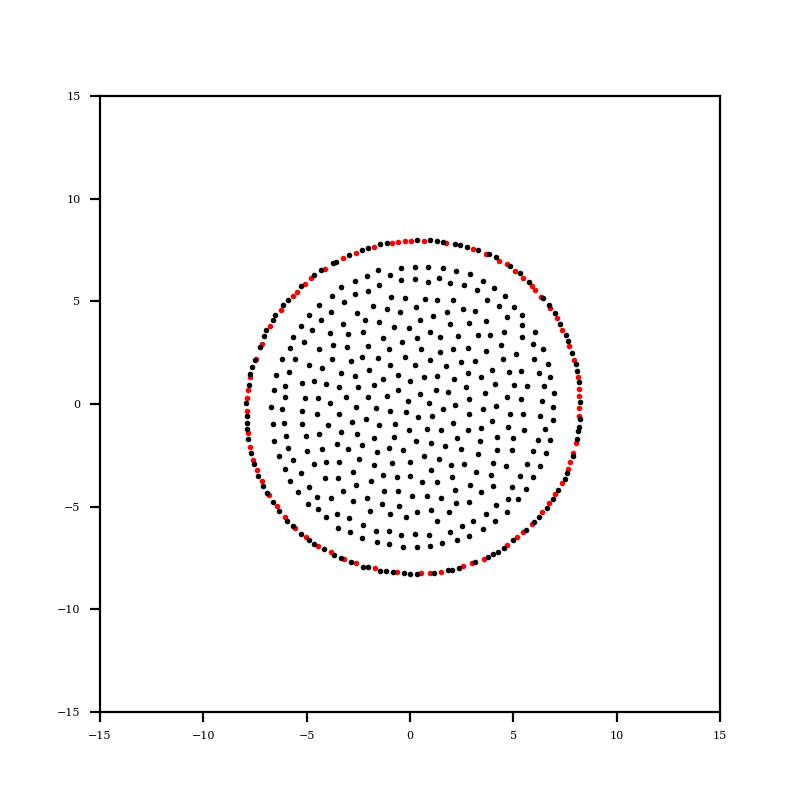

In [7]:
#### Numba-accelerated simulator

b = np.copy(init)
sim = run_simulation(b, with_perimeter=True, step=d_step, **step_args)

<IPython.core.display.Javascript object>


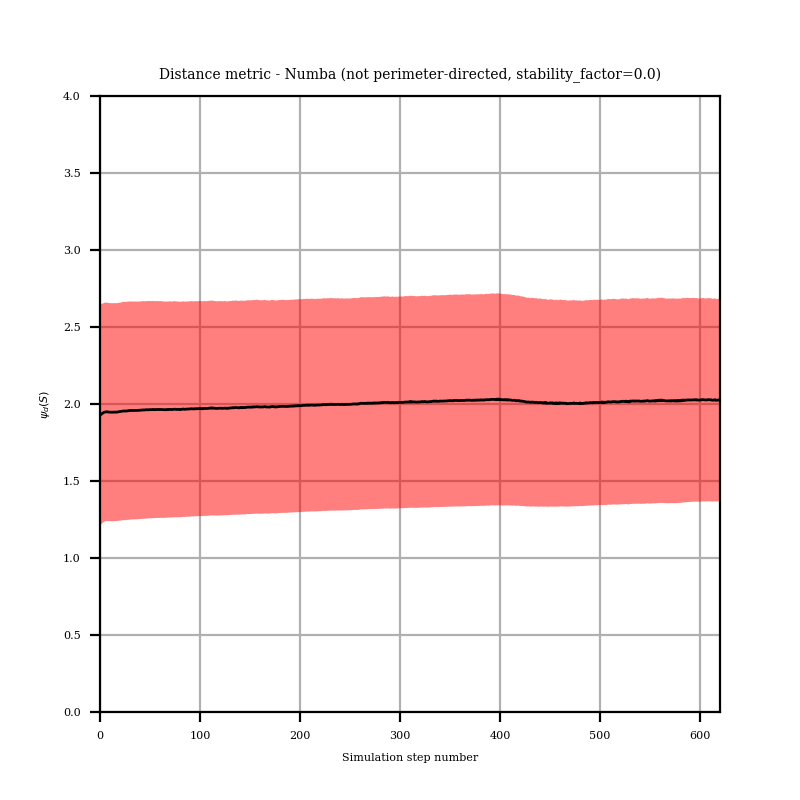

In [8]:
b = np.copy(init)
n_steps = 620                                                               # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                      # create a list of step numbers
mu = []                                                                     # create a list for the mean at each step 
sigma = []                                                                  # create a list for the SD at each step
for i in range(n_steps):
    xv,yv,mag,ang,ecf,erf,ekc,ekr = compute_step(b, **step_args)            # take a step
    m, s = mu_sigma_d(mag, ecf)                                             # compute the mean and SD
    mu += [m]                                                               # add to lists
    sigma += [s]
    apply_step(b)
step_ids = np.array(step_ids)                                               # convert lists to np arrays for easier plotting
mu = np.array(mu)
sigma = np.array(sigma)
fig, ax = plt.subplots(figsize=(4,4))                                       # create a graph
ax.set(xlim=(0, n_steps), ylim=(0, 4))                                      # set the limits of the axes
ax.set_title('Distance metric - Numba (not perimeter-directed, stability_factor=0.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_d(S)$')
ax.grid(True)                                                               # show a grid
ax.plot(step_ids, mu, 'k-')                                                 # plot the mean
ax.fill_between(step_ids, mu + sigma, mu - sigma, facecolor='red', alpha=0.5)   # plot the standard deviation

<IPython.core.display.Javascript object>


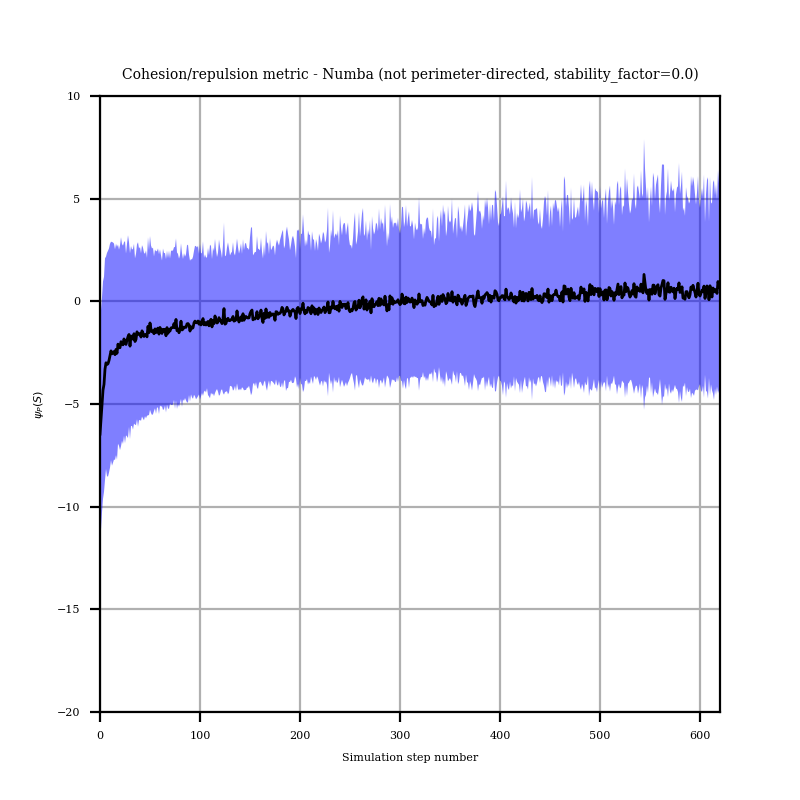

In [9]:
b = np.copy(init)
n_steps = 620                                                                           # set the number of simulation steps to do
step_ids = [i for i in range(n_steps)]                                                  # list of step numbers
mu_p = []                                                                               # create a list for the mean at each step
sigma_p = []                                                                            # create a list for the SD at each step
for i in range(n_steps):                                                                
    compute_step(b, **step_args)                                                        # take a step
    m, s = mu_sigma_p(b)                                                                # get mean and SD
    mu_p += [m]                                                                         # add to lists
    sigma_p += [s]
    apply_step(b)
step_ids = np.array(step_ids)                                                           # convert lists to np arrays for easier plotting
mu_p = np.array(mu_p)
sigma_p = np.array(sigma_p)
fig, ax = plt.subplots(figsize=(4,4))                                                   # create a graph
ax.set(xlim=(0, n_steps), ylim=(-20, 10))  
ax.set_title('Cohesion/repulsion metric - Numba (not perimeter-directed, stability_factor=0.0)')
ax.set_xlabel('Simulation step number')
ax.set_ylabel('$\psi_P(S)$')
ax.grid(True)                                                                           # show a grid
ax.plot(step_ids, mu_p, 'k-')                                                           # plot the mean
ax.fill_between(step_ids, mu_p + sigma_p, mu_p - sigma_p, facecolor='blue', alpha=0.5)  # plot the standard deviation

In [10]:
from datetime import datetime
from os import mkdir, chdir, listdir, getcwd
from shutil import copy
from ipywidgets import widgets

def run_parameter_experiments(n_exps=1000, n_steps=800, etype='random', 
                              values=[0.05, 0.2, 0.5, 0.75, 1.0, 4.0, 16.0, 64.0, 256.0, 1024.0],
                              baseline='experiments/config/baseline.json',
                              data_dir='experiments/data/',
                              results_dir=None):
    '''
    :param n_exps: number of experiments to run
    :param n_steps: number of steps in each run
    :param etype: type of experiment, one of ['random', 'pr', 'pkc', 'pkr', 'one_shot']
    :param values: list of possible parameter values
    :param baseline: file name of the baseline configuration
    :param data_dir: name of the directory to put the results
    '''
    init, swarm_args, step_args = load_swarm(baseline)
    all_params = np.array([ [[1.0, p1], [p2, p3]] for p1 in values for p2 in values for p3 in values ])
    if results_dir is None:
        results_dir = data_dir + str(n_steps) + '_' + datetime.today().strftime('%Y-%m-%dT%H:%M') + '/'
        mkdir(results_dir)
    copy(baseline, results_dir + 'baseline.json')
    if etype == 'random':
        prng = np.random.default_rng()
        pr = (prng.random(n_exps) * (len(values) ** 3)).astype(np.int64) 
        pkc = (prng.random(n_exps) * (len(values) ** 3)).astype(np.int64) 
        pkr = (prng.random(n_exps) * (len(values) ** 3)).astype(np.int64)    
        for e in range(n_exps):
            step_args['pr'] = all_params[pr[e]]
            step_args['pkc'] = all_params[pkc[e]]
            step_args['pkr'] = all_params[pkr[e]]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, swarm_args, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'pr':
        for e in range(len(all_params)):
            step_args['pr'] = all_params[e]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, swarm_args, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'pkc':
        for e in range(len(all_params)):
            step_args['pkc'] = all_params[e]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, swarm_args, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'pkr':
        for e in range(len(all_params)):
            step_args['pkr'] = all_params[e]
            b = np.copy(init)
            for i in range(n_steps):
                d_step(b, **step_args)
            dump_state(b, swarm_args, step_args, path=f'{results_dir}e{e:04}.json')
    elif etype == 'one_shot':
        e = 0
        b = np.copy(init)
        for i in range(n_steps):
            d_step(b, **step_args)
        dump_state(b, swarm_args, step_args, path=f'{results_dir}e{e:04}.json')
    else:
        assert(False)
        
def review_parameter_experiments(review_dir=None, start=0, n_reviews=None):
    '''
    :param review_dir: directory containing the experimental results to review - error if None of review_dir does not exist
    :param start: number of the experiment from which to start the review
    :n_reviews: number of experiments to review - if None review all experiments in review_dir
    '''
    fig, ax = plt.subplots(figsize=(4,4))                   # create a graph
    files = sorted(listdir(review_dir))
    if n_reviews is None or start + n_reviews > len(files):
        n_reviews = len(files) - start - 1
    files = files[start+1:start+n_reviews+1]
    files = list(map(lambda f : review_dir + f, files))
    count = 0
    maxcount = len(files)
    
    def show_experiment(n):
        global exp_state, exp_step_args
        f = files[n]
        b, params = load_state(f)
        exp_state = b
        exp_step_args = {k:v for k,v in params.items() if k in ['scaling', 'exp_rate', 'speed', 'perim_coord', 'stability_factor', 'pr', 'pkc', 'pkr']}
        exp_step_args['pr'] = np.array(step_args['pr'])
        exp_step_args['pkc'] = np.array(step_args['pkc'])
        exp_step_args['pkr'] = np.array(step_args['pkr'])
        x_min = np.amin(b[POS_X]) - 1
        x_max = np.amax(b[POS_X]) + 1
        y_min = np.amin(b[POS_Y]) - 1
        y_max = np.amax(b[POS_Y]) + 1
        ax.cla()                                                # clear the axes
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))        # set the limits of the axes
        ax.set_aspect("equal")
        p = b[PRM].astype(bool)
        ax.set_title(f"{f}\n pr={params['pr']}\n pkc={params['pkc']}\n pkr={params['pkr']}\n kg={params['kg']}")
        ax.plot(b[POS_X, p], b[POS_Y, p], 'ro',  # plot perimeter agents
                b[POS_X, np.logical_not(p)], b[POS_Y, np.logical_not(p)], 'ko', markersize=1) # plot internal agents
        fig.canvas.draw()
        
    def next_event(event):
        nonlocal count, maxcount
        count = (count + 1) % maxcount
        show_experiment(count)

    show_experiment(count)
    cid = fig.canvas.mpl_connect('button_press_event', next_event)
    return fig, cid

In [11]:
%%time
# run_parameter_experiments(1, baseline='experiments/config/dk_outer_proportional.json', etype='one_shot', results_dir='experiments/data/one_shot/')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [12]:
%%time
# run_parameter_experiments(etype='pkc')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [13]:
# exp_state = None
# exp_step_args = None
# review_parameter_experiments('experiments/data/one_shot/')

In [14]:
# x_limits = (np.amin(exp_state[POS_X]) - 5, np.amax(exp_state[POS_X]) + 5)
# y_limits = (np.amin(exp_state[POS_Y]) - 5, np.amax(exp_state[POS_Y]) + 5)
# sim = run_simulation(exp_state, with_perimeter=True, step=d_step, x_limits=x_limits, y_limits=y_limits, **exp_step_args)